In [7]:
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


C:\Users\Jacob\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette_score: 0.2696031366992642
davies_bouldin_score: 1.563376666917013


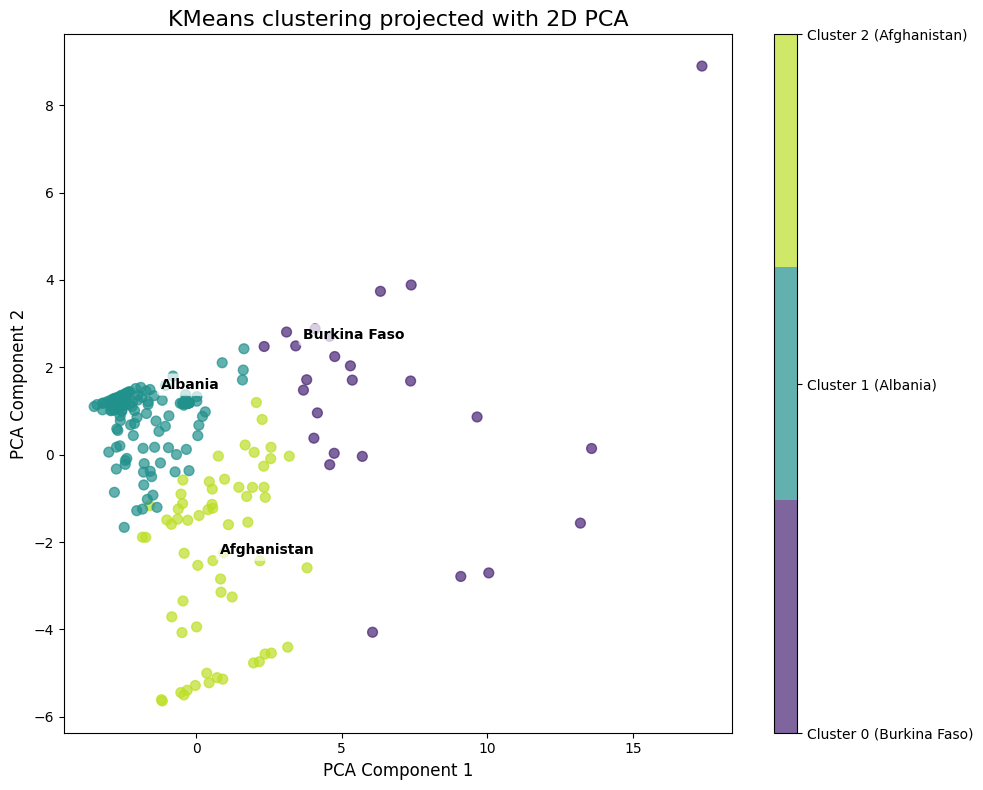

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from utils.functions import plot_clusters_2d
from utils.functions import evaluate_clusters


# Function to process and pivot each dataframe
def process_and_pivot(df, prefix):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df.fillna("Not Available", inplace=True)
    
    df_filtered = df[['Location', 'Period', 'Value']]
    df_pivoted = df_filtered.pivot(index='Location', columns='Period', values='Value')
    df_pivoted = df_pivoted.rename(columns=lambda x: f"{prefix}_{x}")
    
    return df_pivoted.reset_index()

# Load the datasets
advertisingBan = pd.read_csv('../data/advertising_ban_internet.csv')
affordability = pd.read_csv('../data/affordability.csv')
gdp2000Cigs = pd.read_csv('../data/gdp_for_2000_cigs.csv')
healthWarningPhoto = pd.read_csv('../data/health_warning_photo.csv')
requiredHealthWarnings = pd.read_csv('../data/required_health_warning.csv')
obesity = pd.read_csv('../data/country_obesity_percentages_cleaned.csv')

# Process and pivot each dataframe
advertisingBan_pivoted = process_and_pivot(advertisingBan, 'advertisingBan')
affordability_pivoted = process_and_pivot(affordability, 'affordability')
#ageStandardized_pivoted = process_and_pivot(ageStandardized, 'ageStandardized')
gdp2000Cigs_pivoted = process_and_pivot(gdp2000Cigs, 'gdp2000Cigs')
healthWarningPhoto_pivoted = process_and_pivot(healthWarningPhoto, 'healthWarningPhoto')
requiredHealthWarnings_pivoted = process_and_pivot(requiredHealthWarnings, 'requiredHealthWarnings')
obesity_pivoted = process_and_pivot(obesity, 'obesity')

# Merge the pivoted dataframes on 'Location'
combined_df = advertisingBan_pivoted.merge(affordability_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(gdp2000Cigs_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(healthWarningPhoto_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(requiredHealthWarnings_pivoted, on='Location', how='outer')
combined_df = combined_df.merge(obesity_pivoted, on='Location', how='outer')

# Drop 'Location' for clustering
data_for_clustering = combined_df.drop(columns=['Location'])

# Preprocessing pipeline: imputing, encoding, and scaling
numeric_features = data_for_clustering.select_dtypes(include=['float64', 'int64']).columns
categorical_features = data_for_clustering.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Prepare the final data for clustering
clustering_data = preprocessor.fit_transform(data_for_clustering)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(clustering_data)

mask = kmeans.labels_ != -1
data = clustering_data[mask]
labels = kmeans.labels_[mask]

evaluate_clusters(silhouette_score, data, labels)
evaluate_clusters(davies_bouldin_score, data, labels)

plot_clusters_2d(kmeans, clustering_data, combined_df)
